In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import cmocean as cm
import waypoint_distance as wd
import pandas as pd
from pathlib import Path
from datetime import datetime
from matplotlib.dates import DateFormatter
import gsw
import matplotlib.dates as mdates

cube = xr.open_dataset(os.path.expanduser('~/Desktop/Summer 2025 Python/calvert_cube.nc'))
topo = xr.open_dataset(os.path.expanduser('~/Desktop/Summer 2025 Python/british_columbia_3_msl_2013.nc'))
ds = xr.open_dataset('~/Desktop/Summer 2025 Python/Hakai_calvert.nc')

def plot_ts_from_station(ds, station_id, years=[2023, 2024, 2025],
                         depth_range=(100, 450), xlim=None, ylim=None, target_months=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import gsw
    import itertools
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    # Filter and clean
    ds_station = ds.where(ds['station'] == station_id, drop=True)
    ds_station = ds_station.dropna(dim='row', subset=['temperature', 'salinity', 'depth', 'time'])
    ds_station = ds_station.where(ds_station['time'].dt.year.isin(years), drop=True)
    if target_months is not None:
        ds_station = ds_station.where(ds_station['time'].dt.month.isin(target_months), drop=True)

    if ds_station.sizes['row'] < 2:
        print(f"No valid data for station {station_id} in years {years}.")
        return

    # ─── Interpolate profiles onto a uniform depth grid ───
    regular_depth = np.arange(0, 423, 1)
    sigma_theta = gsw.sigma0(ds_station['salinity'], ds_station['temperature'])
    times = np.unique(ds_station['time'].values)

    all_S, all_T = [], []
    cmap = plt.colormaps.get_cmap('jet')
    colors = cmap(np.linspace(0, 1, len(times)))
    marker = itertools.cycle(['o', 'D', 's', 'X', 'P', '^', 'v', '<', '>', '*', 'h'])

    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))
    ax.set_facecolor('lightgrey')

    # Sigma-theta grid
    S_grid, T_grid = np.meshgrid(np.linspace(28, 35, 200),
                                 np.linspace(5.3, 20, 200))
    sigma = gsw.sigma0(S_grid, T_grid)

    for levels, color, lw in [
            (np.linspace(24, 27, 7), 'black', .51),
                        ([25.6], 'white', 0.5),
                        ([25.7], 'lime', 0.5),
                        ([25.8], 'red', 0.5),
                        ([25.9], 'blue', 0.5),
                        ([26.0], 'black', 0.51),
                        ([26.1], 'purple', 0.5),
                        ([26.2], 'salmon', 0.5),
                        ([26.3], 'yellow', 0.5),
                        ([26.4], 'cyan', 0.5)]:
        cs = ax.contour(S_grid, T_grid, sigma, levels=levels,
                        colors=color, linewidths=lw, linestyles='--')
        if lw != 0.5:
            ax.clabel(cs, fmt='%1.2f', fontsize=9, inline=True)

    # Plot each profile
    for i, t in enumerate(times):
        profile = ds_station.where(ds_station['time'] == t, drop=True)
        if profile.sizes['row'] < 2:
            continue

        depth = profile['depth'].values
        temp = profile['temperature'].values
        sal = profile['salinity'].values

        mask = (depth >= depth_range[0]) & (depth <= depth_range[1])
        temp = temp[mask]
        sal = sal[mask]

        temp_masked = ~np.isnan(temp) & ~np.isnan(sal)
        if np.any(temp_masked):
            ax.scatter(sal[temp_masked], temp[temp_masked],
                       color=colors[i],
                       s=90,
                       marker=next(marker),
                       linewidth=0.2,
                       label=pd.Timestamp(t).strftime('%d %b %Y'))

            all_S.extend(sal[temp_masked])
            all_T.extend(temp[temp_masked])

    # Axis limits
    if all_S and all_T:
        all_S = np.array(all_S)
        all_T = np.array(all_T)
        if xlim is None:
            xlim = (np.nanmin(all_S) - 0.1, np.nanmax(all_S) + 0.1)
        if ylim is None:
            ylim = (np.nanmin(all_T) - 0.1, np.nanmax(all_T) + 0.1)

    ax.set_xlabel("Salinity (psu)")
    ax.set_ylabel(r"$\theta$ (°C)")
    ax.set_title(f"T–S Diagram at {station_id}")
    ax.legend(fontsize=9, loc='upper right')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()

def plot_ts(cube, along_values, target_years=[2023, 2024],
            shallowest_depth=None, xlim=None, ylim=None, target_months=None):
    """
    Scatter-style T–S diagram for selected along-track locations and years,
    with sigma-theta contours and consistent marker cycling.
    """

    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import gsw

    if isinstance(along_values, (int, float)):
        along_values = [along_values]

    cube = cube.where(cube['along'].isin(along_values), drop=True)
    if shallowest_depth is not None:
        cube = cube.where(cube['depth'] > shallowest_depth, drop=True)

    transects = cube.transect.values
    times = [pd.to_datetime(str(t)[:8]) for t in transects]
    selected_idxs = [i for i, t in enumerate(times)
                     if t.year in target_years and (target_months is None or t.month in target_months)]

    if not selected_idxs:
        print(f"No valid transects for years {target_years} at along = {along_values}")
        return

    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))

    cmap = plt.colormaps.get_cmap('turbo')
    color_map = cmap(np.linspace(0, 1, len(selected_idxs)))
    # markers = itertools.cycle(['o', 'D', 's', 'X', 'P', '^', 'v', '<', '>', '*', 'h', '+'])
    all_S, all_T = [], []

    depths = cube['depth'].values
    depth_mask = (depths >= 100) & (depths <= 450)
    depth_idxs = np.where(depth_mask)[0]

    # Sigma-theta grid
    S_grid, T_grid = np.meshgrid(np.linspace(28, 35, 200),
                                 np.linspace(5.3, 20, 200))
    sigma = gsw.sigma0(S_grid, T_grid)

    for levels, color, lw in [
        (np.linspace(24, 27, 7), 'black', 0.5),
        (np.linspace(26, 27, 11), 'black', 0.5),
        ([26], 'black', 2),
        ([25.6], 'yellow', 2), ([25.7], 'lime', 2), ([25.8], 'red', 2), ([25.9], 'blue', 2),
        ([26.6], 'yellow', 2), ([26.7], 'lime', 2), ([26.8], 'red', 2), ([26.9], 'blue', 2)
    ]:
        cs = ax.contour(S_grid, T_grid, sigma, levels=levels,
                        colors=color, linewidths=lw, linestyles='--')
        if lw != 0.5:
            ax.clabel(cs, fmt='%1.2f', fontsize=9, inline=True)

    # For each transect index
    for i, idx in enumerate(selected_idxs):
        this_along_vals = cube['temperature'].coords['along'].values

        for along_val in along_values:
            # Find nearest along index
            along_idx = np.argmin(np.abs(this_along_vals - along_val))
            # marker_style = next(markers)

            # Extract T and S
            T = cube['temperature'][idx, depth_idxs, along_idx].values.flatten()
            S = cube['salinity'][idx, depth_idxs, along_idx].values.flatten()
            date = times[idx]
            label = f"{date.strftime('%d %b %Y')} @ {int(along_val)} m"

            mask = ~np.isnan(T) & ~np.isnan(S)

            if np.any(mask):
                ax.scatter(
                    S[mask], T[mask],
                    color=color_map[i],
                    label=label,
                    s=60,
                    linewidth=0.5,
                    # marker=marker_style
                    marker = 'o')
                all_S.extend(S[mask])
                all_T.extend(T[mask])

    # Combine all S and T for auto-limits
    if all_S and all_T:
        all_S = np.array(all_S)
        all_T = np.array(all_T)
        if xlim is None:
            xlim = (np.nanmin(all_S) - 0.1, np.nanmax(all_S) + 0.1)
        if ylim is None:
            ylim = (np.nanmin(all_T) - 0.1, np.nanmax(all_T) + 0.1)

    ax.set_xlabel("Salinity (psu)")
    ax.set_ylabel(r"$\theta$ (°C)")
    ax.set_title(f"T–S Diagram at {', '.join([str(a)+' m' for a in along_values])}")
    ax.legend(fontsize=9, loc='upper right')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()

# plot_ts(cube, along_values=(6000, 7000, 8000, 9000), target_years=[2024], shallowest_depth = 0, xlim = (31, 34), ylim = (5, 11))



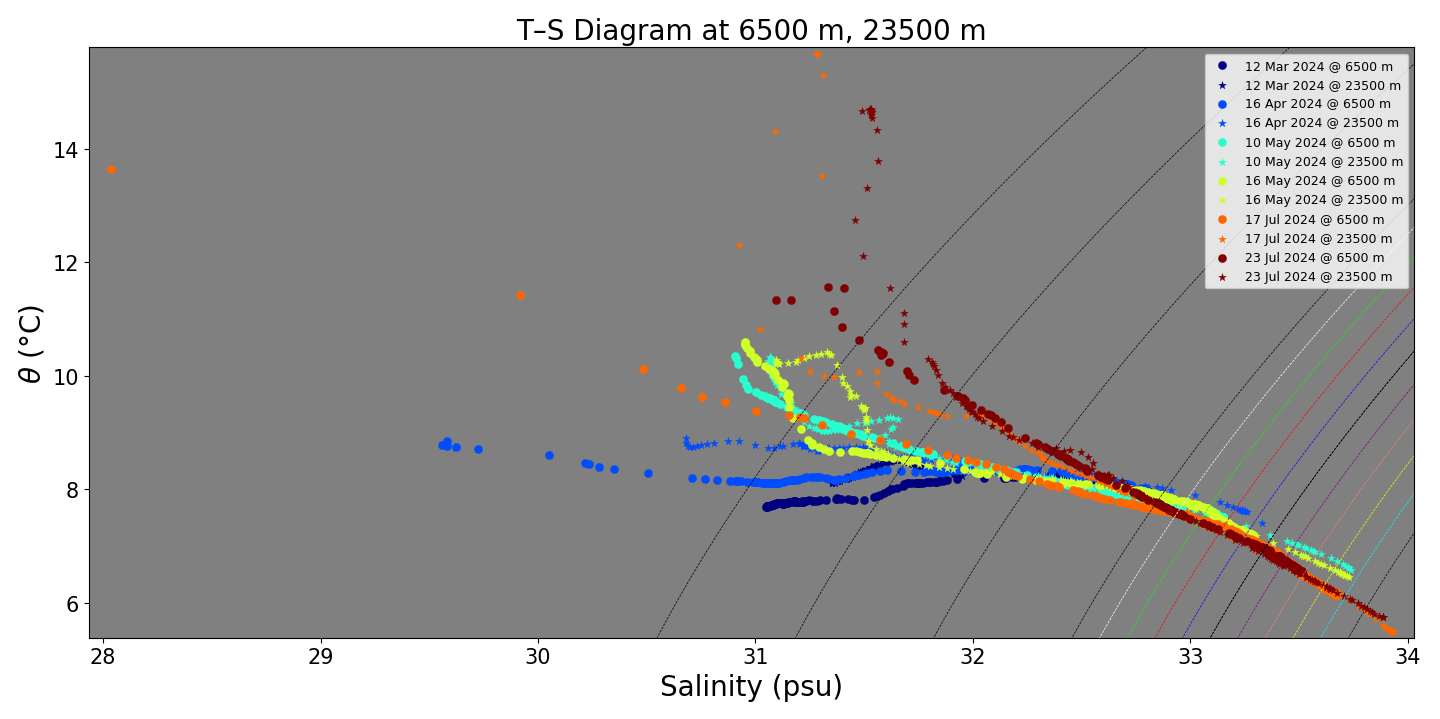

In [28]:
def plot_ts(cube, along_values, target_years=[2023, 2024],
            shallowest_depth=None, xlim=None, ylim=None, target_months=None):
    """
    Scatter-style T–S diagram with sigma-theta contours.
    Different along_values get different marker shapes.
    Prints number of valid T–S points per profile.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import itertools
    import gsw

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    if isinstance(along_values, (int, float)):
        along_values = [along_values]

    cube = cube.where(cube['along'].isin(along_values), drop=True)

    transects = cube.transect.values
    times = [pd.to_datetime(str(t)[:8]) for t in transects]
    selected_idxs = [i for i, t in enumerate(times)
                     if t.year in target_years and (target_months is None or t.month in target_months)]

    if not selected_idxs:
        print(f"No valid transects for years {target_years} at along = {along_values}")
        return

    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))
    ax.set_facecolor('grey')

    # Colormap for time
    cmap = plt.colormaps.get_cmap('jet')
    color_map = cmap(np.linspace(0, 1, len(selected_idxs)))

    # One shape per along_value
    marker_map = {
        along_values[0]: 'o',   # circle
        along_values[1]: '*',}

    all_S, all_T = [], []

    # Sigma-theta grid
    S_grid, T_grid = np.meshgrid(np.linspace(28, 35, 200),
                                 np.linspace(5.3, 20, 200))
    sigma = gsw.sigma0(S_grid, T_grid)

    for levels, color, lw in [
            (np.linspace(24, 27, 7), 'black', 0.5),
            ([25.6], 'white', 0.5),
            ([25.7], 'lime', 0.5),
            ([25.8], 'red', 0.5),
            ([25.9], 'blue', 0.5),
            ([26.0], 'black', 0.5),
            ([26.1], 'purple', 0.5),
            ([26.2], 'salmon', 0.5),
            ([26.3], 'yellow', 0.5),
            ([26.4], 'cyan', 0.5)]:
        cs = ax.contour(S_grid, T_grid, sigma, levels=levels,
                        colors=color, linewidths=lw, linestyles='--')
        if lw != 0.5:
            ax.clabel(cs, fmt='%1.2f', fontsize=9, inline=True)

    for i, idx in enumerate(selected_idxs):
        this_along_vals = cube['temperature'].coords['along'].values
        date = times[idx]

        for along_val in along_values:
            along_idx = np.argmin(np.abs(this_along_vals - along_val))

            # Corrected to use all depth levels
            T = cube['temperature'][idx, :, along_idx].values.flatten()
            S = cube['salinity'][idx, :, along_idx].values.flatten()

            mask = ~np.isnan(T) & ~np.isnan(S)
            count = np.count_nonzero(mask)

            if count > 0:
                label = f"{date.strftime('%d %b %Y')} @ {int(along_val)} m"
                # print(f"{label}: {count} valid depth points")

                ax.scatter(
                    S[mask], T[mask],
                    color=color_map[i],
                    label=label,
                    marker=marker_map.get(along_val, 'o'),
                    linewidth=0.2)
                all_S.extend(S[mask])
                all_T.extend(T[mask])

    # Axis limits
    if all_S and all_T:
        all_S = np.array(all_S)
        all_T = np.array(all_T)
        if xlim is None:
            xlim = (np.nanmin(all_S) - 0.1, np.nanmax(all_S) + 0.1)
        if ylim is None:
            ylim = (np.nanmin(all_T) - 0.1, np.nanmax(all_T) + 0.1)

    ax.set_xlabel("Salinity (psu)")
    ax.set_ylabel(r"$\theta$ (°C)")
    ax.set_title(f"T–S Diagram at {', '.join([str(a)+' m' for a in along_values])}")
    ax.legend(fontsize=9, loc='upper right')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()

plot_ts(
    cube,
    along_values=[6500, 23500],   # in meters
    target_years=[2024],
    target_months= [3,4,5,6, 7, 8],
    shallowest_depth=0)

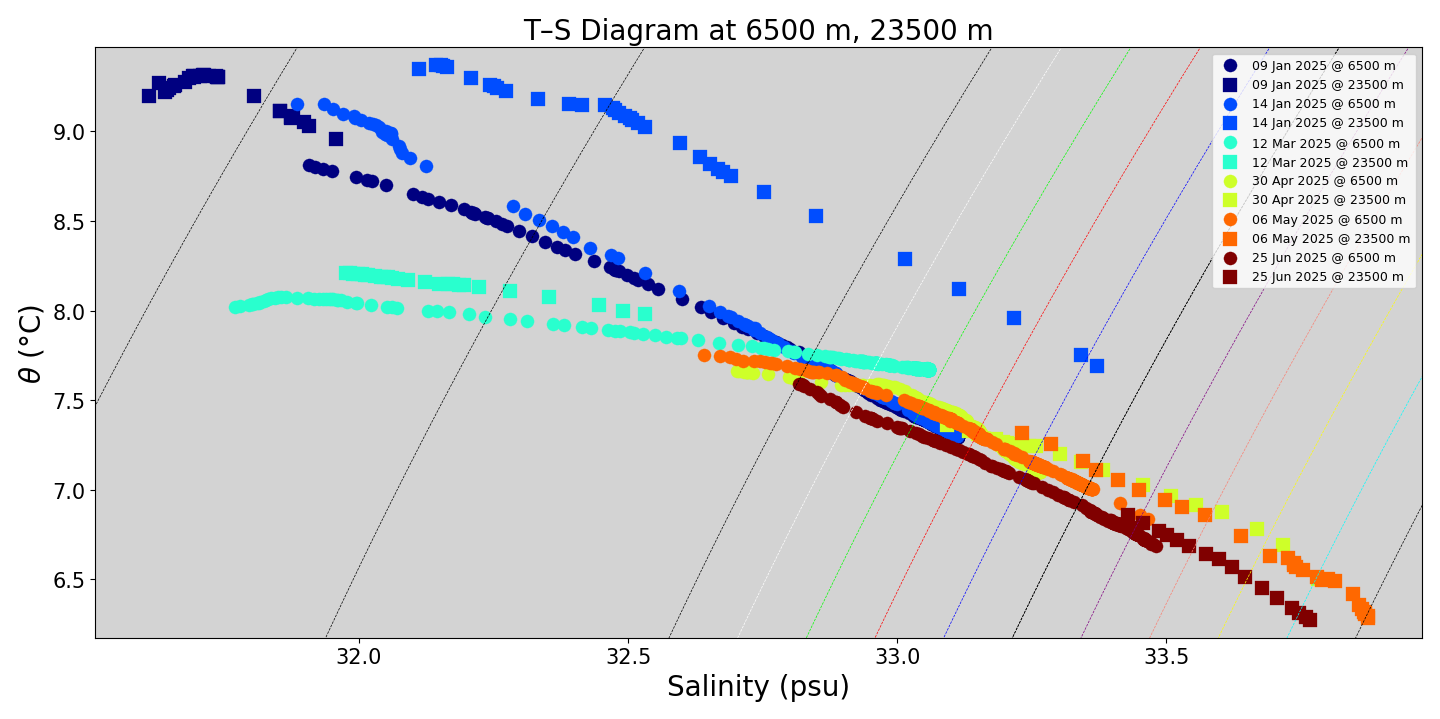

In [8]:
plot_ts(
    cube,
    along_values=[6500, 23500],   # in meters
    target_years=[2025],
    shallowest_depth=0)

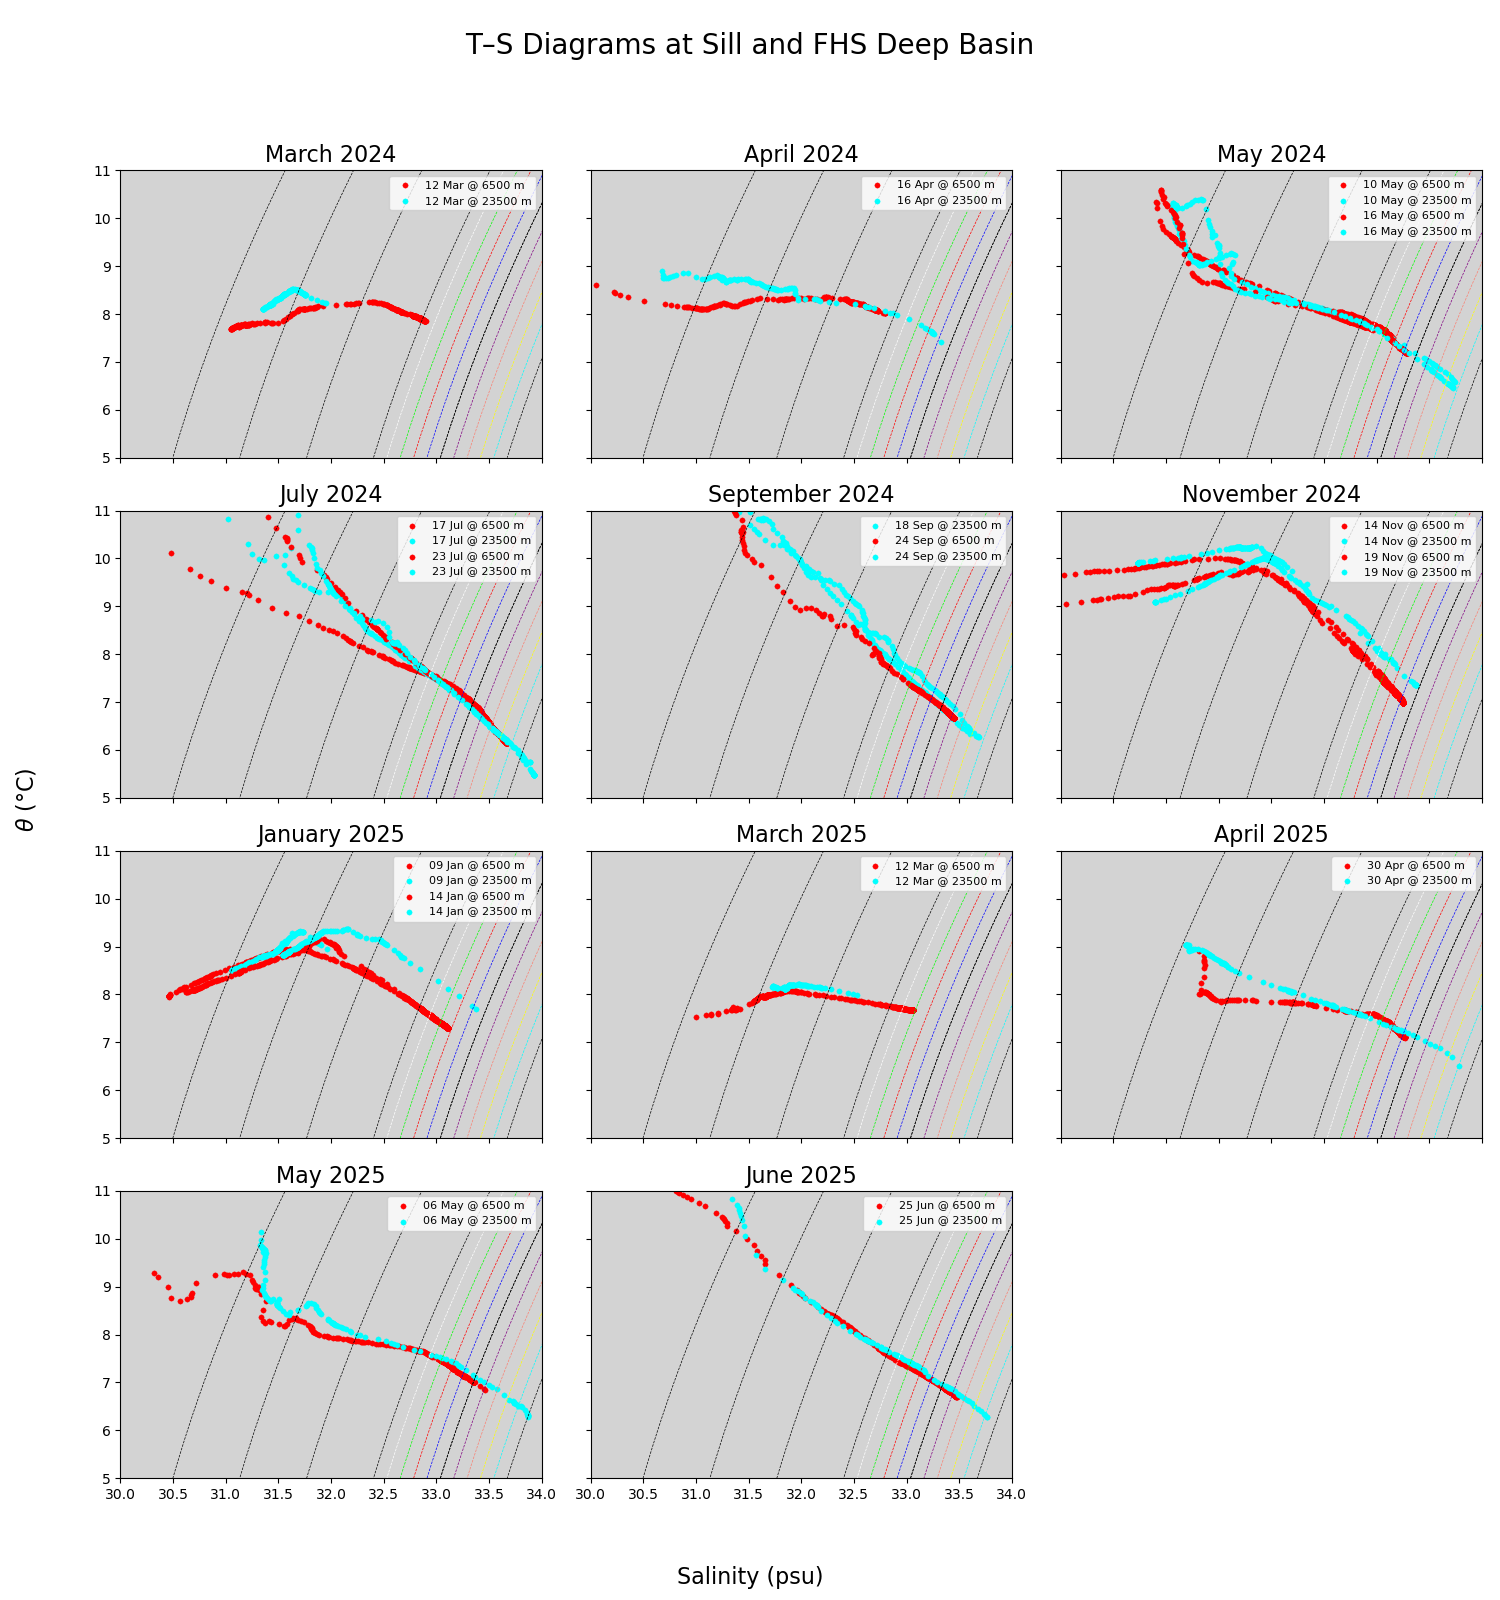

In [18]:
def plot_ts_grid(cube, along_values, target_years=[2023, 2024],
                     shallowest_depth=None, xlim=None, ylim=None, target_months=None,
                     ncols=3):
    """
    T–S diagrams with one subplot per (year, month).
    Same marker shape, custom colors for each along-track location.
    Shared x/y labels shown once.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import gsw

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 20})

    if isinstance(along_values, (int, float)):
        along_values = [along_values]

    # ─── Filter by station ─────────────────────────────────────
    cube = cube.where(cube['along'].isin(along_values), drop=True)

    # ─── Select time points ────────────────────────────────────
    transects = cube.transect.values
    times = [pd.to_datetime(str(t)[:8]) for t in transects]
    selected = [(i, t) for i, t in enumerate(times)
                if t.year in target_years and (target_months is None or t.month in target_months)]

    if not selected:
        print(f"No valid transects for years {target_years} at along = {along_values}")
        return

    # ─── Group by (year, month) ────────────────────────────────
    grouped = {}
    for i, t in selected:
        ym = (t.year, t.month)
        grouped.setdefault(ym, []).append((i, t))

    sorted_keys = sorted(grouped.keys())
    n_panels = len(sorted_keys)
    nrows = int(np.ceil(n_panels / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharex=True, sharey=True)
    axes = axes.flatten()

    # ─── Custom colors ─────────────────────────────────────────
    station_colors = {
        6500: 'red',
        23500: 'cyan'
    }
    marker_style = '.'

    # ─── Sigma-theta grid ──────────────────────────────────────
    S_grid, T_grid = np.meshgrid(np.linspace(28, 35, 200),
                                 np.linspace(5, 20, 200))
    sigma = gsw.sigma0(S_grid, T_grid)

    all_S, all_T = [], []

    for j, (year, month) in enumerate(sorted_keys):
        ax = axes[j]
        ax.set_facecolor('lightgrey')

        # ─── Density Contours ───────────────────────────────────
        for levels, contour_color, lw in [
                (np.linspace(24, 27, 7), 'black', 0.5),
                ([25.6], 'white', 0.5), ([25.7], 'lime', 0.5), ([25.8], 'red', 0.5),
                ([25.9], 'blue', 0.5), ([26.0], 'black', 0.5), ([26.1], 'purple', 0.5),
                ([26.2], 'salmon', 0.5), ([26.3], 'yellow', 0.5), ([26.4], 'cyan', 0.5)]:
            cs = ax.contour(S_grid, T_grid, sigma, levels=levels,
                            colors=contour_color, linewidths=lw, linestyles='--')
            if lw != 0.5:
                ax.clabel(cs, fmt='%1.2f', fontsize=8, inline=True)

        for i, t in grouped[(year, month)]:
            this_along_vals = cube['temperature'].coords['along'].values

            for along_val in along_values:
                along_idx = np.argmin(np.abs(this_along_vals - along_val))
                T = cube['temperature'][i, :, along_idx].values.flatten()
                S = cube['salinity'][i, :, along_idx].values.flatten()
                mask = ~np.isnan(T) & ~np.isnan(S)

                if np.count_nonzero(mask) > 0:
                    color = station_colors.get(along_val, 'gray')
                    ax.scatter(S[mask], T[mask],
                               s=60,
                               color=color,
                               marker=marker_style,
                               linewidth=0.2,
                               label=f"{t.strftime('%d %b')} @ {int(along_val)} m")
                    all_S.extend(S[mask])
                    all_T.extend(T[mask])

        ax.set_title(f"{pd.to_datetime(f'{year}-{month:02}', format='%Y-%m').strftime('%B %Y')}")
        ax.legend(fontsize=8, loc='upper right')

    # ─── Axis Limits ───────────────────────────────────────────
    if all_S and all_T:
        all_S = np.array(all_S)
        all_T = np.array(all_T)
        if xlim is None:
            xlim = (np.nanmin(all_S) - 0.1, np.nanmax(all_S) + 0.1)
        if ylim is None:
            ylim = (np.nanmin(all_T) - 0.1, np.nanmax(all_T) + 0.1)

        for ax in axes:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

    # ─── Shared Labels ─────────────────────────────────────────
    fig.text(0.5, 0.01, "Salinity (psu)", ha='center', fontsize=16)
    fig.text(0.01, 0.5, r"$\theta$ (°C)", va='center', rotation='vertical', fontsize=16)

    # ─── Remove unused axes & title ────────────────────────────
    for j in range(n_panels, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"T–S Diagrams at Sill and FHS Deep Basin")
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plot_ts_grid(
    cube,
    along_values=[6500, 23500],
    target_years=[2024, 2025],
    target_months=[1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    xlim=(30, 34),
    ylim=(5, 11))

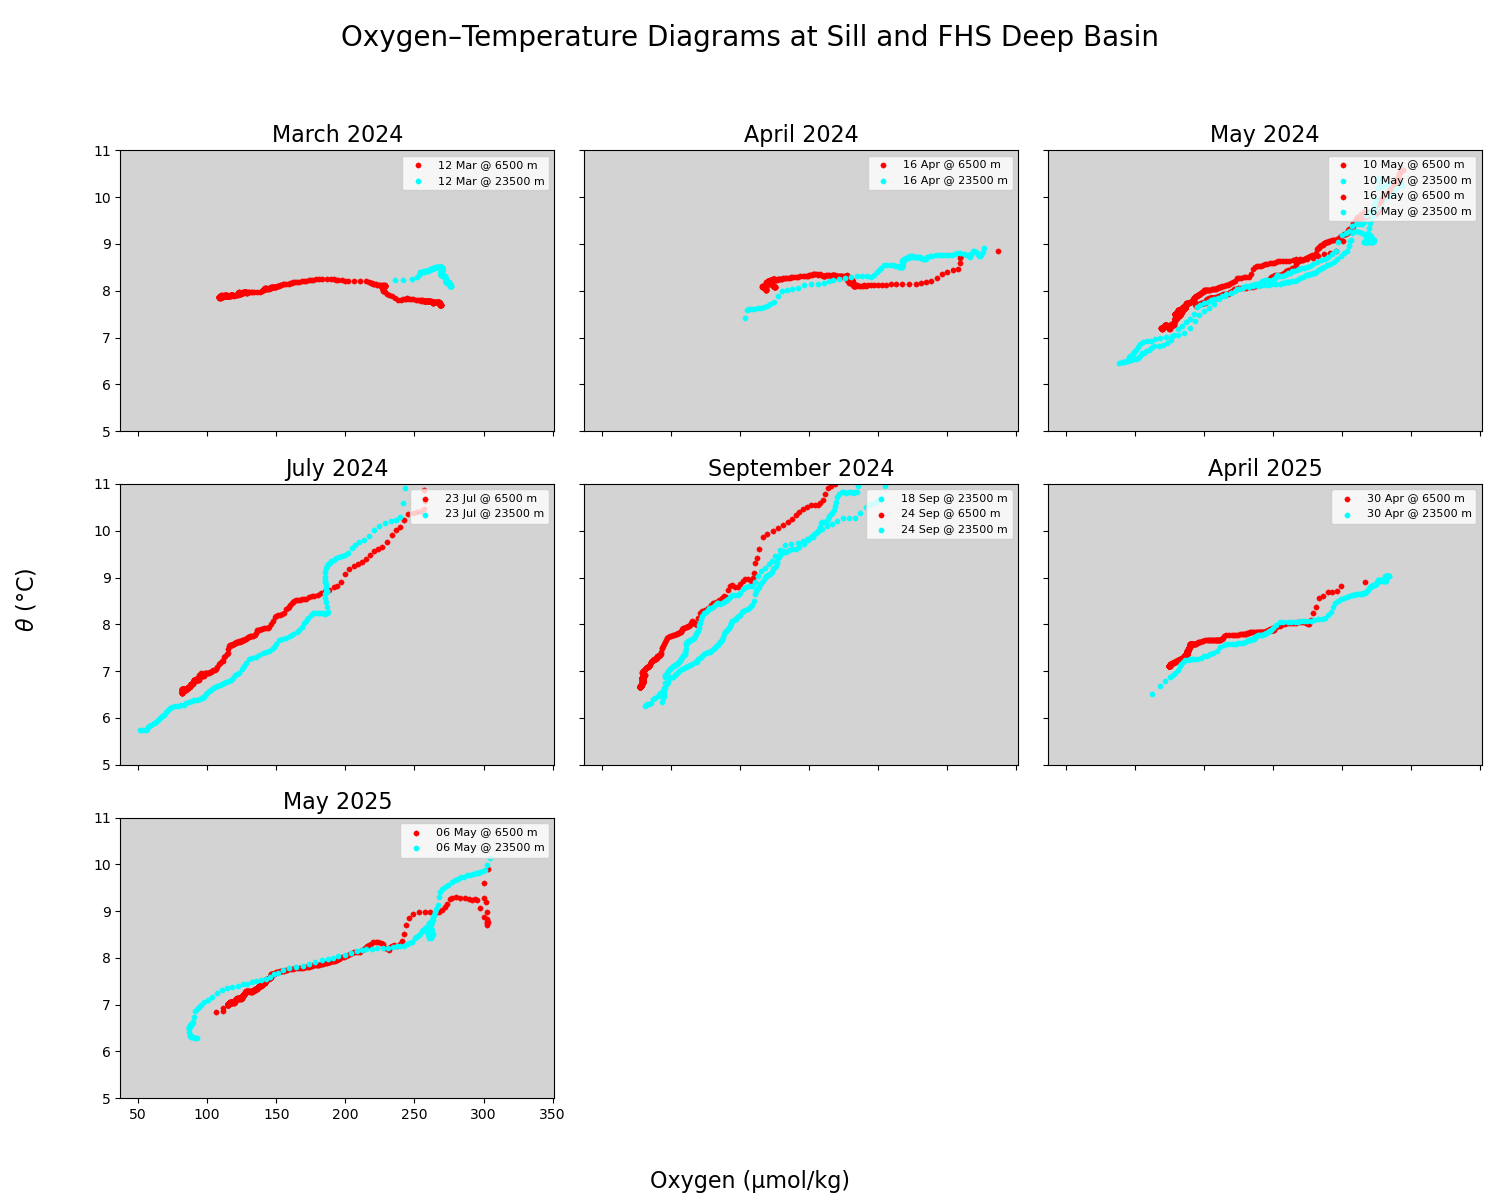

In [11]:

def plot_to_grid(cube, along_values, target_years=[2023, 2024],
                 shallowest_depth=None, xlim=None, ylim=None,
                 target_months=None, ncols=3):
    """
    O2–Temp diagrams with one subplot per (year, month).
    Shared labels, custom color per along-track location.
    Only plots months that contain valid data.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 20})

    if isinstance(along_values, (int, float)):
        along_values = [along_values]

    cube = cube.where(cube['along'].isin(along_values), drop=True)

    transects = cube.transect.values
    times = [pd.to_datetime(str(t)[:8]) for t in transects]
    selected = [(i, t) for i, t in enumerate(times)
                if t.year in target_years and (target_months is None or t.month in target_months)]

    if not selected:
        print(f"No valid transects for years {target_years} at along = {along_values}")
        return

    grouped = {}
    for i, t in selected:
        ym = (t.year, t.month)
        grouped.setdefault(ym, []).append((i, t))

    # Filter out empty (year, month) groups
    sorted_keys = []
    for key in sorted(grouped.keys()):
        has_data = False
        for i, _ in grouped[key]:
            for along_val in along_values:
                along_idx = np.argmin(np.abs(cube['along'].values - along_val))
                O2 = cube['oxygen_concentration'][i, :, along_idx].values.flatten()
                T = cube['temperature'][i, :, along_idx].values.flatten()
                mask = ~np.isnan(O2) & ~np.isnan(T)
                if np.count_nonzero(mask) > 0:
                    has_data = True
                    break
            if has_data:
                break
        if has_data:
            sorted_keys.append(key)

    if not sorted_keys:
        print("No valid months with data.")
        return

    n_panels = len(sorted_keys)
    nrows = int(np.ceil(n_panels / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharex=True, sharey=True)
    axes = axes.flatten()

    station_colors = {
        6500: 'red',
        23500: 'cyan'
    }
    marker_style = '.'

    all_O2, all_T = [], []

    for j, (year, month) in enumerate(sorted_keys):
        ax = axes[j]
        ax.set_facecolor('lightgrey')

        for i, t in grouped[(year, month)]:
            this_along_vals = cube['along'].values

            for along_val in along_values:
                along_idx = np.argmin(np.abs(this_along_vals - along_val))

                O2 = cube['oxygen_concentration'][i, :, along_idx].values.flatten()
                T = cube['temperature'][i, :, along_idx].values.flatten()
                mask = ~np.isnan(O2) & ~np.isnan(T)

                if np.count_nonzero(mask) > 0:
                    color = station_colors.get(along_val, 'gray')
                    ax.scatter(O2[mask], T[mask],
                               s=60,
                               color=color,
                               marker=marker_style,
                               linewidth=0.2,
                               label=f"{t.strftime('%d %b')} @ {int(along_val)} m")
                    all_O2.extend(O2[mask])
                    all_T.extend(T[mask])

        ax.set_title(f"{pd.to_datetime(f'{year}-{month:02}', format='%Y-%m').strftime('%B %Y')}")
        ax.legend(fontsize=8, loc='upper right')

    if all_O2 and all_T:
        if xlim is not None:
            for ax in axes:
                ax.set_xlim(xlim)
        if ylim is not None:
            for ax in axes:
                ax.set_ylim(ylim)

    fig.text(0.5, 0.01, "Oxygen (μmol/kg)", ha='center', fontsize=16)
    fig.text(0.01, 0.5, r"$\theta$ (°C)", va='center', rotation='vertical', fontsize=16)

    for j in range(n_panels, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Oxygen–Temperature Diagrams at Sill and FHS Deep Basin")
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plot_to_grid(
    cube,
    along_values=[6500, 23500],
    target_years=[2024, 2025],
    target_months=[1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    # xlim=(30, 34),
    ylim=(5, 11))

In [10]:
%matplotlib widget

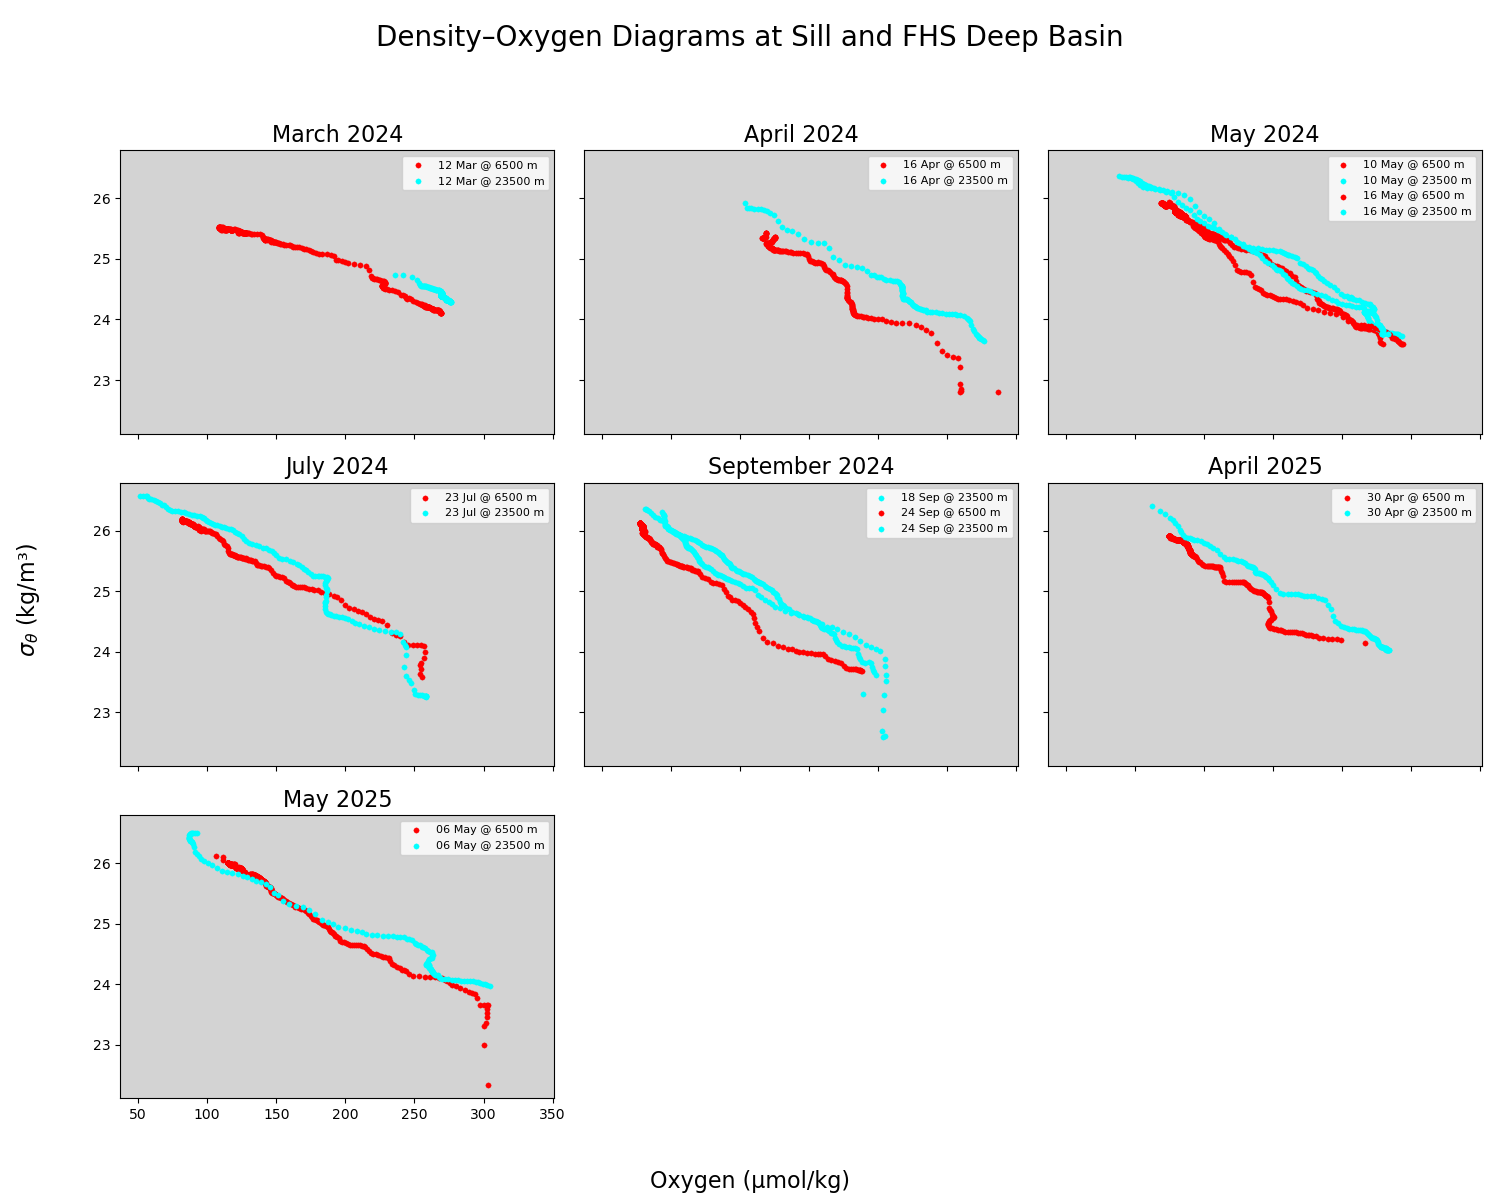

In [ ]:
def plot_to_grid_density_oxygen(cube, along_values, target_years=[2023, 2024],
                                 shallowest_depth=None, xlim=None, ylim=None,
                                 target_months=None, ncols=3):
    """
    Density (sigma_theta) vs. Oxygen diagrams with one subplot per (year, month).
    Shared labels, custom color per along-track location.
    Only plots months with valid oxygen data.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import gsw

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 20})

    if isinstance(along_values, (int, float)):
        along_values = [along_values]

    cube = cube.where(cube['along'].isin(along_values), drop=True)

    transects = cube.transect.values
    times = [pd.to_datetime(str(t)[:8]) for t in transects]
    selected = [(i, t) for i, t in enumerate(times)
                if t.year in target_years and (target_months is None or t.month in target_months)]

    if not selected:
        print(f"No valid transects for years {target_years} at along = {along_values}")
        return

    # Group by (year, month)
    grouped = {}
    for i, t in selected:
        ym = (t.year, t.month)
        grouped.setdefault(ym, []).append((i, t))

    # Filter to only months with valid oxygen data
    filtered_keys = []
    for key in sorted(grouped.keys()):
        entries = grouped[key]
        has_data = False
        for i, _ in entries:
            for along_val in along_values:
                along_idx = np.argmin(np.abs(cube['along'].values - along_val))
                O2 = cube['oxygen_concentration'][i, :, along_idx].values
                if np.any(~np.isnan(O2)):
                    has_data = True
                    break
            if has_data:
                break
        if has_data:
            filtered_keys.append(key)

    n_panels = len(filtered_keys)
    nrows = int(np.ceil(n_panels / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharex=True, sharey=True)
    axes = axes.flatten()

    station_colors = {
        6500: 'red',
        23500: 'cyan'
    }
    marker_style = '.'

    all_sig, all_O2 = [], []

    for j, (year, month) in enumerate(filtered_keys):
        ax = axes[j]
        ax.set_facecolor('lightgrey')

        for i, t in grouped[(year, month)]:
            this_along_vals = cube['oxygen_concentration'].coords['along'].values

            for along_val in along_values:
                along_idx = np.argmin(np.abs(this_along_vals - along_val))

                S = cube['salinity'][i, :, along_idx].values
                T = cube['temperature'][i, :, along_idx].values
                O2 = cube['oxygen_concentration'][i, :, along_idx].values

                mask = ~np.isnan(S) & ~np.isnan(T) & ~np.isnan(O2)

                if np.count_nonzero(mask) > 0:
                    sig = gsw.sigma0(S[mask], T[mask])
                    color = station_colors.get(along_val, 'gray')

                    ax.scatter(O2[mask], sig,
                               s=60,
                               color=color,
                               marker=marker_style,
                               linewidth=0.2,
                               label=f"{t.strftime('%d %b')} @ {int(along_val)} m")
                    all_sig.extend(sig)
                    all_O2.extend(O2[mask])

        ax.set_title(f"{pd.to_datetime(f'{year}-{month:02}', format='%Y-%m').strftime('%B %Y')}")
        ax.legend(fontsize=8, loc='upper right')

    if all_sig and all_O2:
        all_sig = np.array(all_sig)
        all_O2 = np.array(all_O2)
        if xlim is not None:
            for ax in axes:
                ax.set_xlim(xlim)
        if ylim is not None:
            for ax in axes:
                ax.set_ylim(ylim)

    fig.text(0.5, 0.01, "Oxygen (μmol/kg)", ha='center', fontsize=16)
    fig.text(0.01, 0.5, r"$\sigma_\theta$ (kg/m³)", va='center', rotation='vertical', fontsize=16)

    for j in range(n_panels, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Density–Oxygen Diagrams at Sill and FHS Deep Basin")
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plot_to_grid_density_oxygen(
    cube,
    along_values=[6500, 23500],
    target_years=[2024, 2025],
    target_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    # xlim=(24.5, 27.5),  # optional
    # ylim=(0, 160)       # optional
)